# Sommaire
1. [Importation des librairies et chargement des données](#0-bullet) <br>
2. [EDA et Preprocessing](#1-bullet) <br>
    1. [Analyse exploratoire](#2-bullet) <br>
        1 - [Gestion des outliers](#3-bullet) <br>
        2 - [Feature engineering](#4-bullet) <br>
        3 - [Encodage des variables catégorielles](#5-bullet) <br>
        4 - [Traitement des NaN via SimpleImputer](#6-bullet) <br>
        5 - [Stadardisation via RobustScaler](#7-bullet) <br>
3. [Modeling](#8-bullet) <br>
    1. [Split train/test](#9-bullet) <br>
    2. [Dummy classifiers](#10-bullet) <br>
    3. [Rééquilibrage via SMOTE](#11-bullet) <br>
    4. [Re-entrainement après rééquilibrage des classes](#12-bullet) <br>
    5. [Test de modèles de classification](#13-bullet) <br>
        1 - [RidgeClassifier](#14-bullet) <br>
        2 - [LogisticRegression](#15-bullet) <br>
        3 - [SGDClassifier](#16-bullet) <br>
        4 - [DecisionTreeClassifier](#17-bullet) <br>
        5 - [RandomForest](#18-bullet) <br>
        6 - [XGBoost](#19-bullet) <br>
    6. [Fine-tuning](#20-bullet) <br>
        1 - [Fine-tuning RandomForest](#21-bullet) <br>
        2 - [Fine-tuning XGBoost](#22-bullet) <br>
    7. [Fonction de coût métier et réentrainement d’XGBOOST](#23-bullet) <br>    
    8. [Feature importance](#24-bullet) <br>
        1 - [Feature importance globale](#25-bullet) <br>
        2 - [Feature importance locale](#26-bullet) <br>    
        


## 1. Importation des librairies et chargement des données<a class="anchor" id="0-bullet"></a>

In [1]:
# Bibliothèques classiques
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import time, pickle
import os
import matplotlib.pyplot as plt
import warnings # supress warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Sklearn models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Fine-tuning
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
import hyperopt.pyll.stochastic

# Evaluation  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
import shap

In [2]:
# Les options d'affichage
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
# Les paramètres des graphiques
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

#### Les 9 datasets à disposition:
##### application_{train|test}.csv
Il s’agit du tableau principal, divisé en deux fichiers pour l'entrainement(Train) (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Chaque ligne représente un prêt dans notre échantillon de données.

##### bureau.csv
Tous les crédits antérieurs des clients fournis par d’autres institutions financières qui ont été déclarés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait dans le rapport du bureau de crédit avant la date de la demande.

##### bureau_balance.csv
Soldes mensuels des crédits antérieurs dans le rapport du bureau de crédit. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur signalé à l’agence d’évaluation du crédit – c.-à-d. le tableau a (#prêts dans l’échantillon #nombre de crédits relatifs précédents #nombre de mois où nous avons des antécédents observables pour les crédits précédents).

##### POS_CASH_balance.csv
Aperçus mensuels du solde des anciens POS (point of sales) et des prêts en espèces que le demandeur avait contractés auprès de Crédit à l’habitation. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur au crédit à l’habitation (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c.-à-d. que le tableau a (#Nombre de prêts dans l’échantillon (#Nombre de crédits antérieurs relatifs #Nombre de mois au cours desquels nous avons des antécédents observables pour les crédits précédents)

##### credit_card_balance.csv
Instantanés mensuels du solde des cartes de crédit antérieures que le demandeur détient auprès de Crédit à l’habitation. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur au crédit à l’habitation (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c.-à-d. que le tableau a (#Nombre de prêts dans l’échantillon #Nombre de cartes de crédit antérieures relatives #Nombre de mois où nous avons des antécédents observables pour la carte de crédit précédente)

##### previous_application.csv
Toutes les demandes antérieures de crédit à l’habitation de clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.

##### installments_payments.csv
Historique de remboursement pour les crédits déjà déboursés dans le crédit à l’habitation liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d’un versement OU d’un versement correspondant à un paiement d’un crédit à l’habitation antérieur lié à des prêts dans notre échantillon.

##### HomeCredit_columns_description.csv
Ce fichier contient les descriptions des colonnes des différents fichiers de données.

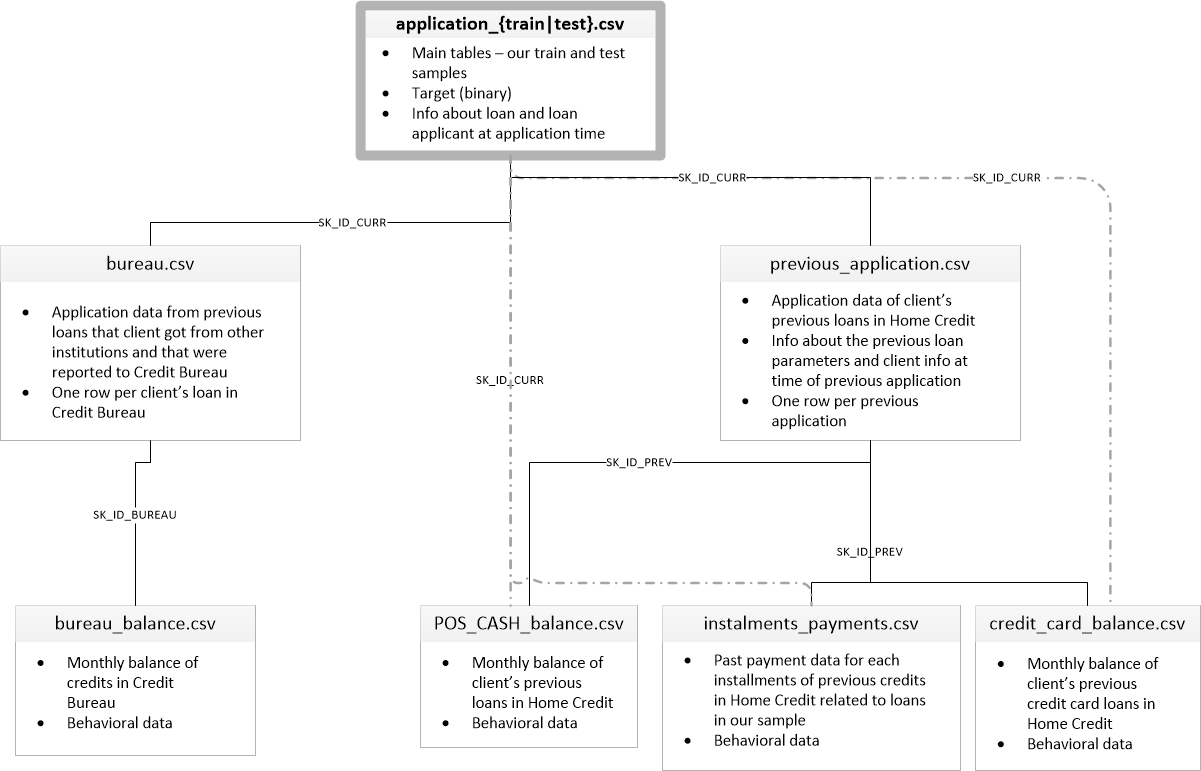

In [4]:
# chargement des données

application_train = pd.read_csv('./Datas/application_train.csv', sep=',')
bureau = pd.read_csv('./Datas/bureau.csv', sep=',')
bureau_balance = pd.read_csv('./Datas/bureau_balance.csv', sep=',')
previous_application = pd.read_csv('./Datas/previous_application.csv', sep=',')
installments_payments = pd.read_csv('./Datas/installments_payments.csv', sep=',')
credit_card_balance = pd.read_csv('./Datas/credit_card_balance.csv', sep=',')
POS_CASH_balance = pd.read_csv('./Datas/POS_CASH_balance.csv', sep=',')
application_test = pd.read_csv('./Datas/application_test.csv', sep=',')

In [5]:
# chargement de la documentation  

description = pd.read_csv('./Datas/home/HomeCredit_columns_description.csv',encoding='Latin-1')
description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [6]:
# signification de la variables "target"
description['Description'][1]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [7]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("Descriptifs des datasets : ")
    return(comparative_table)

## 2. EDA et Preprocessing<a class="anchor" id="1-bullet"></a>

### 1. Analyse exploratoire<a class="anchor" id="2-bullet"></a>

In [8]:
# Descriptifs des fichiers
data_describe(glob.glob('./Datas/*.csv'))

Descriptifs des datasets : 


,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
./Datas/application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
./Datas/POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
./Datas/credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
./Datas/installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
./Datas/application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
./Datas/bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620
./Datas/previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
./Datas/bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846


In [9]:
def variable_stats(folder):
    '''
    fonction qui effectue des statistiques des variables de type object et des variables numériques
    Retourne deux dataframes: 
    - 1 dataframe de statistique des variables object
    - 1 dataframe de statistique des variables numériques
    '''

    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file)
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

In [10]:
# description des variables catégorielles

variable_stats(folder=glob.glob('./Datas/*.csv'))[0]

features   dtype    nan  \
./Datas/application_test.csv     0     NAME_CONTRACT_TYPE  object    0.0   
                                 1            CODE_GENDER  object    0.0   
                                 2           FLAG_OWN_CAR  object    0.0   
                                 3        FLAG_OWN_REALTY  object    0.0   
                                 4        NAME_TYPE_SUITE  object  911.0   
...                                                   ...     ...    ...   
./Datas/previous_application.csv 12          CHANNEL_TYPE  object    0.0   
                                 13  NAME_SELLER_INDUSTRY  object    0.0   
                                 14      NAME_YIELD_GROUP  object    0.0   
                                 15   PRODUCT_COMBINATION  object  346.0   
./Datas/bureau_balance.csv       0                 STATUS  object    0.0   

                                          count  
./Datas/application_test.csv     0      48744.0  
                                 1      48744.0  
                                 2      48744.0  
                                 3      48744.0  
                                 4      47833.0  
...                                         ...  
./Datas/previous_application.csv 12   1670214.0  
                                 13   1670214.0  
                                 14   1670214.0  
                                 15   1669868.0  
./Datas/bureau_balance.csv       0   27299925.0  

[54 rows x 4 columns]

In [11]:
# description des variables numériques 

variable_stats(folder=glob.glob('./Datas/*.csv'))[1]

features    dtype  \
./Datas/application_test.csv     0                  SK_ID_CURR    int64   
                                 1                CNT_CHILDREN    int64   
                                 2            AMT_INCOME_TOTAL  float64   
                                 3                  AMT_CREDIT  float64   
                                 4                 AMT_ANNUITY  float64   
...                                                        ...      ...   
./Datas/previous_application.csv 18              DAYS_LAST_DUE  float64   
                                 19           DAYS_TERMINATION  float64   
                                 20  NFLAG_INSURED_ON_APPROVAL  float64   
./Datas/bureau_balance.csv       0                SK_ID_BUREAU    int64   
                                 1              MONTHS_BALANCE    int64   

                                        nan     count     mean       std  \
./Datas/application_test.csv     0        0     48744   277796  103169.5   
                                 1        0     48744        0       0.7   
                                 2        0     48744   178431  101522.6   
                                 3        0     48744   516740  365397.0   
                                 4       24     48720    29426   16016.4   
...                                     ...       ...      ...       ...   
./Datas/previous_application.csv 18  673065    997149    76582  149647.4   
                                 19  673065    997149    81992  153303.5   
                                 20  673065    997149        0       0.5   
./Datas/bureau_balance.csv       0        0  27299925  6036297  492348.9   
                                 1        0  27299925      -30      23.9   

                                           min        max  
./Datas/application_test.csv     0    100001.0   456250.0  
                                 1         0.0       20.0  
                                 2     26941.5  4410000.0  
                                 3     45000.0  2245500.0  
                                 4      2295.0   180576.0  
...                                        ...        ...  
./Datas/previous_application.csv 18    -2889.0   365243.0  
                                 19    -2874.0   365243.0  
                                 20        0.0        1.0  
./Datas/bureau_balance.csv       0   5001709.0  6842888.0  
                                 1       -96.0        0.0  

[285 rows x 8 columns]

In [12]:
print('Forme du dataset application_train : ', application_train.shape)
print('Forme du dataset application_test : ', application_test.shape)

Forme du dataset application_train :  (307511, 122)
Forme du dataset application_test :  (48744, 121)


<AxesSubplot: ylabel='None'>

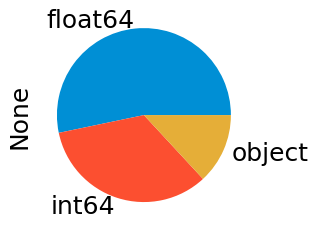

In [13]:
# afficher les types de variables 
application_train.dtypes.value_counts().plot.pie()

<AxesSubplot: ylabel='None'>

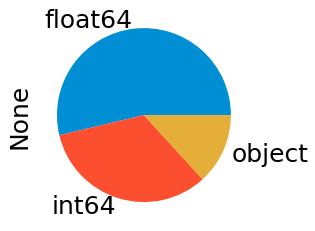

In [14]:
# afficher les types de variables 
application_test.dtypes.value_counts().plot.pie()

In [15]:
# sauvegarde d'un échatillon des données test avant le prétraitement pour en servir dans le dashbord
application_test_sample = application_test.head(100)
application_test_sample.to_csv('test_sample_brute.csv')  

In [16]:
# vérification si la variable "target" est la seule différence entre les deux df
display(application_train.columns.difference(application_test.columns))

Index(['TARGET'], dtype='object')

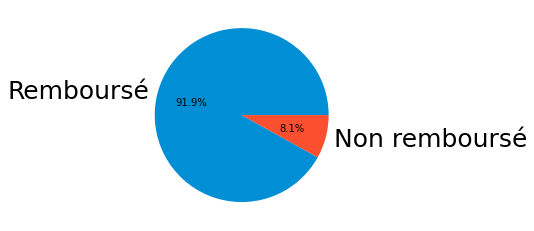

In [17]:
# afficher la distribution de "target"  
target_cent_train=application_train['TARGET'].value_counts()/len(application_train)*100
plt.pie(target_cent_train,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
           )
plt.show()

Nous remarquons qu'il y a deux classes déséquilibrées Notons des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps ( Target = 0) que de prêts non remboursés (Target = 1) .

Cette information peut nous être très utile dans l'étape de modélisation.

In [18]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [19]:
# vérifier les valeurs uniques dans les variables de type object à encoder après
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [20]:
# vérifier les variables qui ont plus de nan
def nan_check(data):
    '''vérifier les données manquantes'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 des données manquantes')
nan_check(application_train)[:10]

TOP 10 des données manquantes


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [21]:
# vérifier le nombre de colonnes contenant des nans

print("nombre de colonnes total dans l'échantillon d'entrainement: " + str(len(nan_check(application_train))))

print("nombre de colonnes dans l'échantillon d'entrainement avec des valeurs manquantes: " + 
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))

nombre de colonnes total dans l'échantillon d'entrainement: 122
nombre de colonnes dans l'échantillon d'entrainement avec des valeurs manquantes: 67


#### I - Gestion des outliers <a class="anchor" id="3-bullet"></a>

In [22]:
# vérifier l'age des clients qui est calculé en nombre de jours
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [23]:
# Nous rectifions les valeurs aberantes négatives.
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 1.0, 'Age des clients')

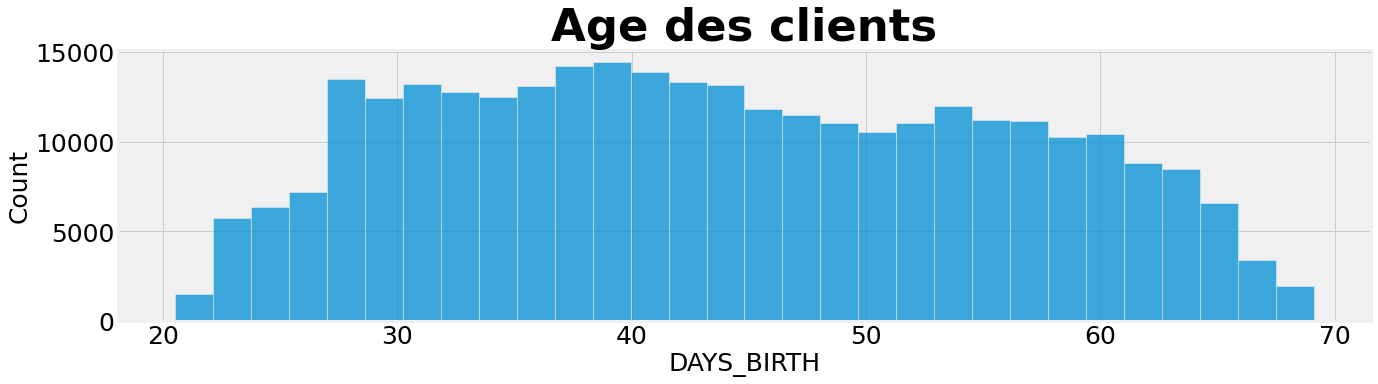

In [24]:
# distribution d'âge des clients
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age des clients')
#show()

In [28]:
# Signification de la variable 'DAYS_EMPLOYED'
description['Description'][18]

'How many days before the application the person started current employment'

In [29]:
# vérifier la variable dans l'échantillon d'entrainement
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [30]:
# vérifier la variable dans l'échantillon de test
application_test['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, "Les jours d'emploi")

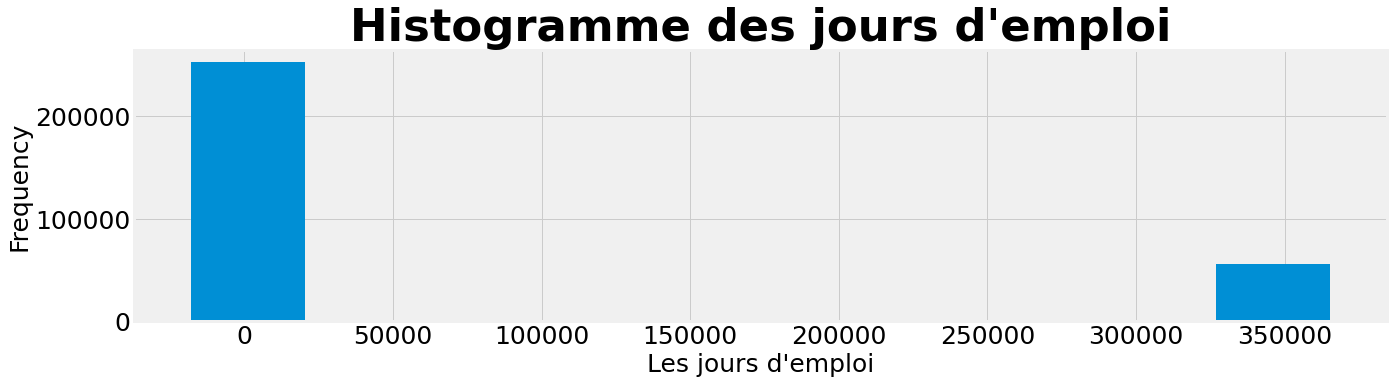

In [31]:
application_train['DAYS_EMPLOYED'].plot.hist(title = "Histogramme des jours d'emploi", figsize=(20,5));
plt.xlabel("Les jours d'emploi")
#show()

In [32]:
print("%0.0f valeur totale des jours de travail dans les données d'entrainement" % application_train.shape[0])
print("%0.0f valeurs avec 365243 jours de travail dans les données d'entrainement" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f valeur totale des jours de travail dans les données de test" % application_test.shape[0])
print("%0.0f valeurs avec 365243 jours de travail dans les données de test" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))

307511 valeur totale des jours de travail dans les données d'entrainement
55374 valeurs avec 365243 jours de travail dans les données d'entrainement
48744 valeur totale des jours de travail dans les données de test
9274 valeurs avec 365243 jours de travail dans les données de test


In [33]:
# Création d'une colonne d'indicateur de valeurs aberrantes
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

Text(0.5, 0, 'Days Employment')

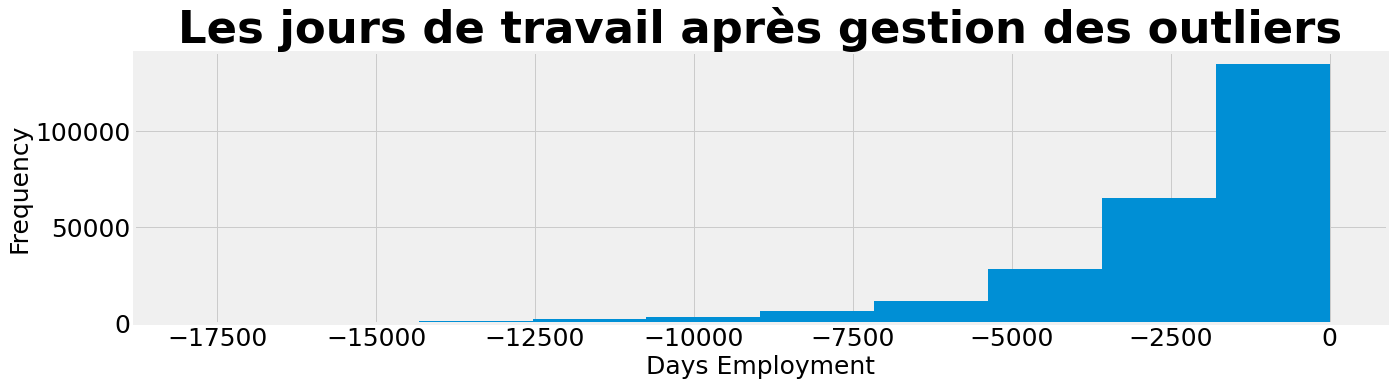

In [34]:
# remplacer la valeur aberrate par NaN 
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# re-afficher l'histogramme après le remplacement
application_train['DAYS_EMPLOYED'].plot.hist(title ='Les jours de travail après gestion des outliers', figsize=(20,5))
plt.xlabel('Days Employment')
#show()


In [35]:
application_test['DAYS_EMPLOYED'].describe()

count    39470.000000
mean     -2476.738941
std       2307.963913
min     -17463.000000
25%      -3328.750000
50%      -1765.000000
75%       -861.000000
max         -1.000000
Name: DAYS_EMPLOYED, dtype: float64

In [36]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.4f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    #show()

In [37]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage avec prêt non remboursé (trget = 1)")

    for p in ax.patches:
                percentage = '{:.4f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    #show()

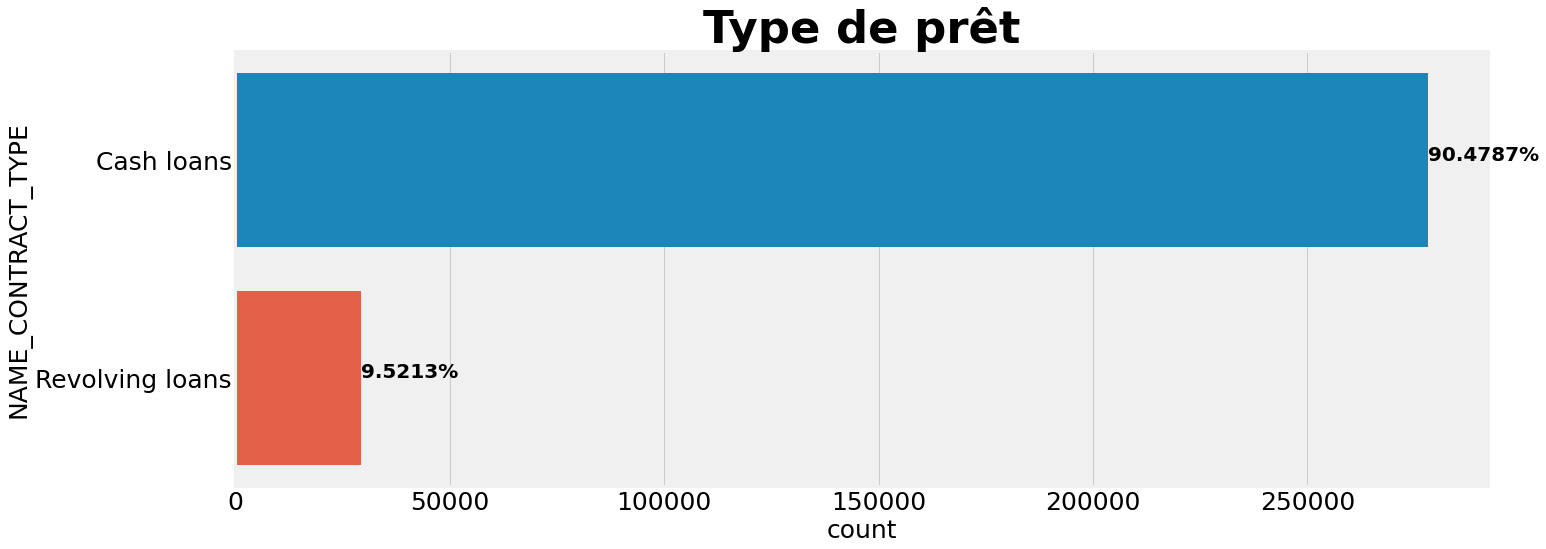

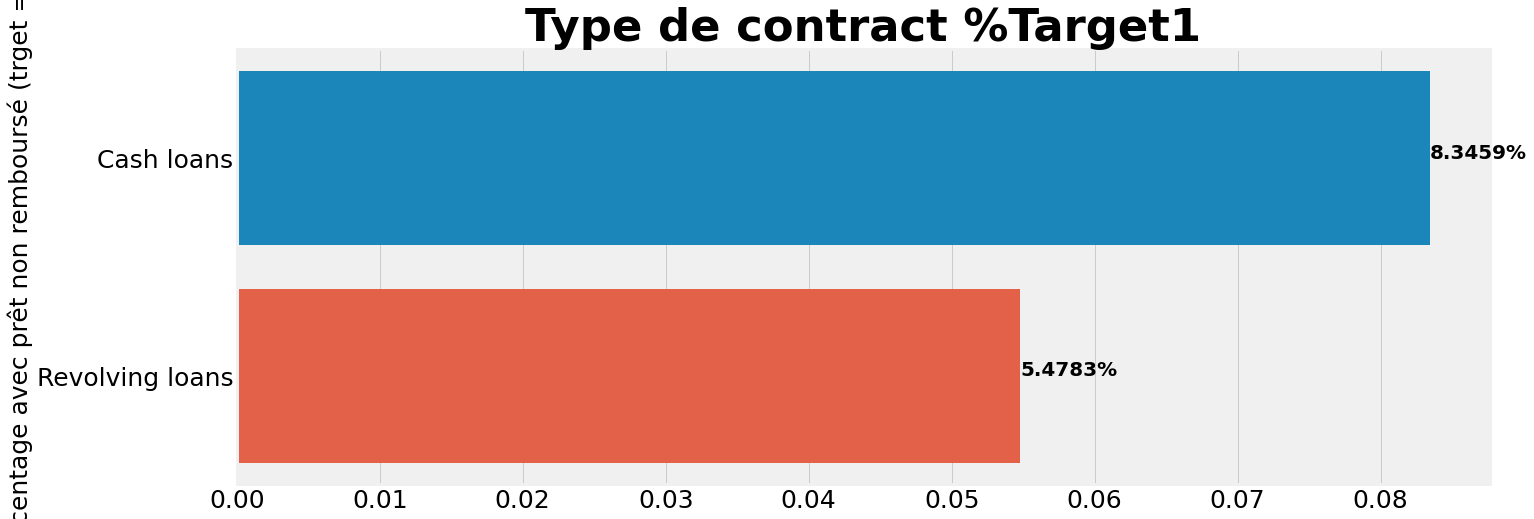

In [38]:
#Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec 
#la valeur TARGET 1(prêt non retourné).
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type de prêt")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type de contract %Target1")

Les crédits revolving ne représentent qu'une petite fraction (10%) du nombre total de prêts.
Un plus grand nombre de crédits revolving, par rapport à leur fréquence, ne sont pas remboursés.

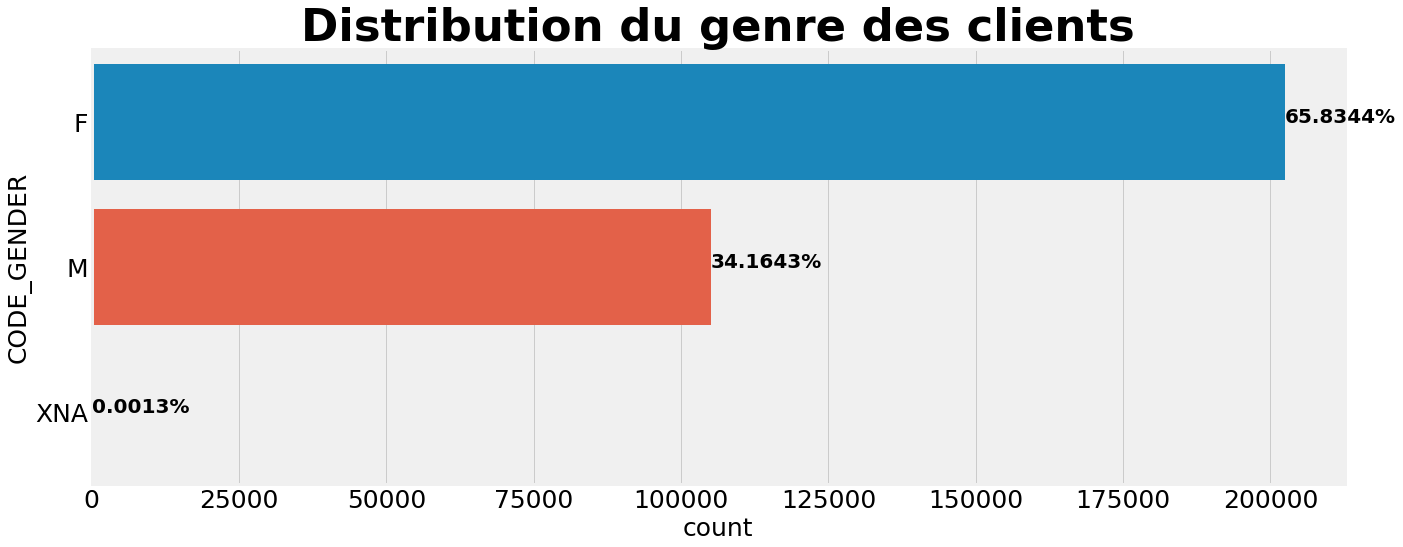

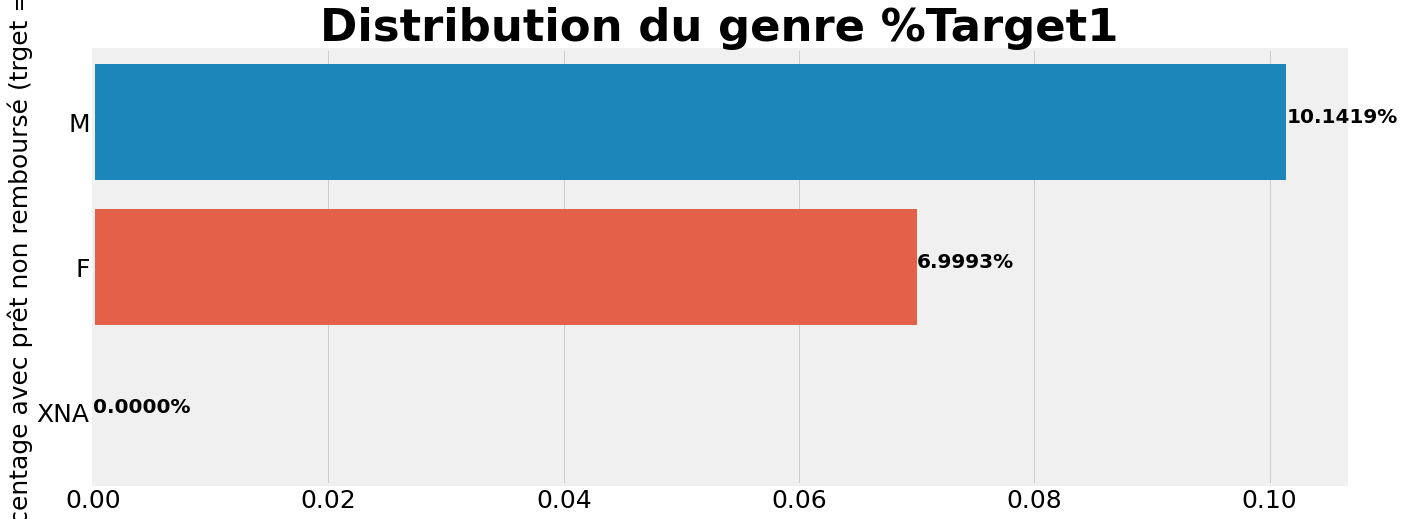

In [39]:
#Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec 
#la valeur TARGET 1 (prêt non retourné).
plot_stat(application_train, 'CODE_GENDER',"Distribution du genre des clients")
plot_percent_target1(application_train, 'CODE_GENDER',"Distribution du genre %Target1")

Le nombre femme est presque le double du nombre des hommes qui ont emprunté des crédits. En ce qui concerne le pourcentage de crédits non reboursés, les hommes ont plus de mal à rembourser leurs prêts (10%), comparativement aux femmes (7%).

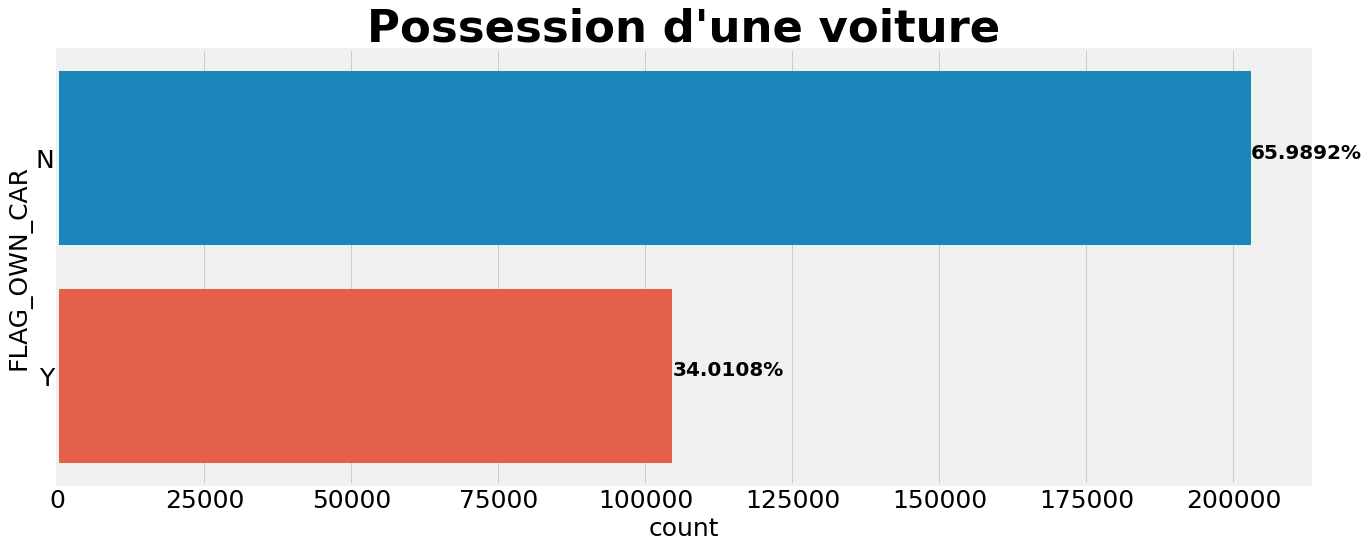

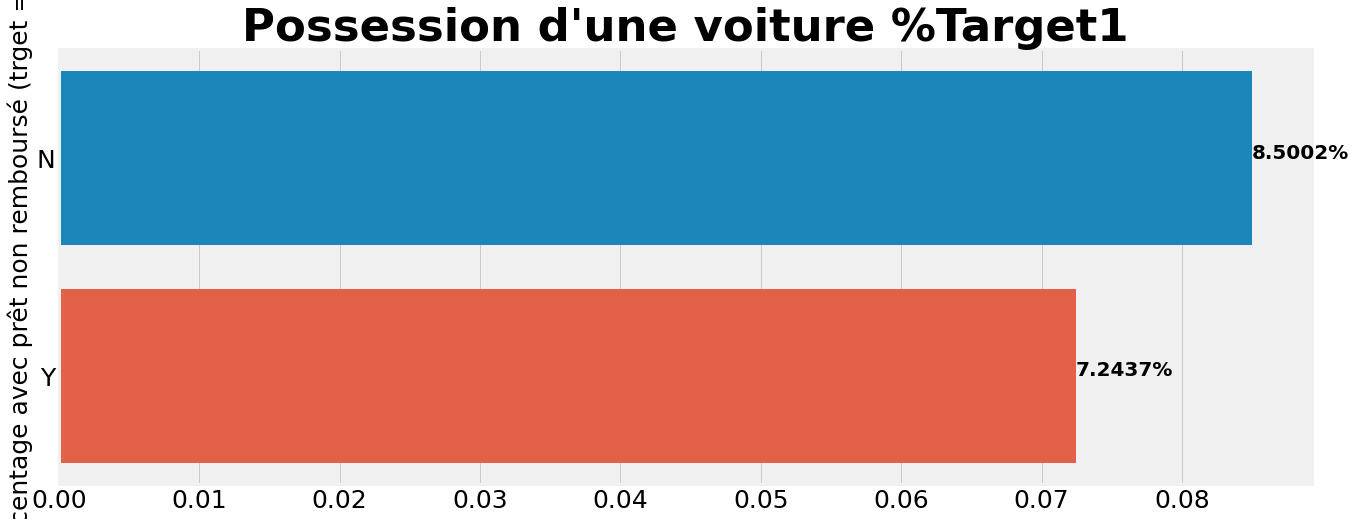

In [40]:
#Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas.
plot_stat(application_train, 'FLAG_OWN_CAR',"Possession d'une voiture")
plot_percent_target1(application_train, 'FLAG_OWN_CAR',"Possession d'une voiture %Target1")

Les deux catégories (propriétaire ou non d'une voiture) ont des taux de non-remboursement assez proche: environ 8%.

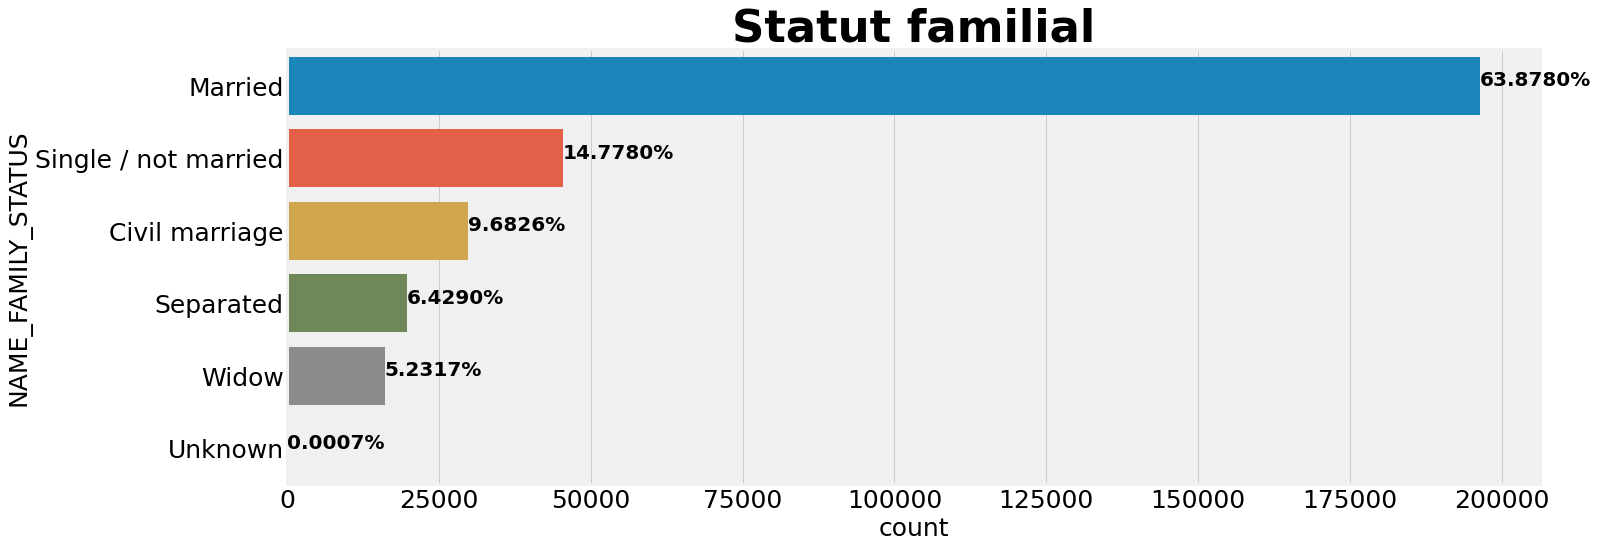

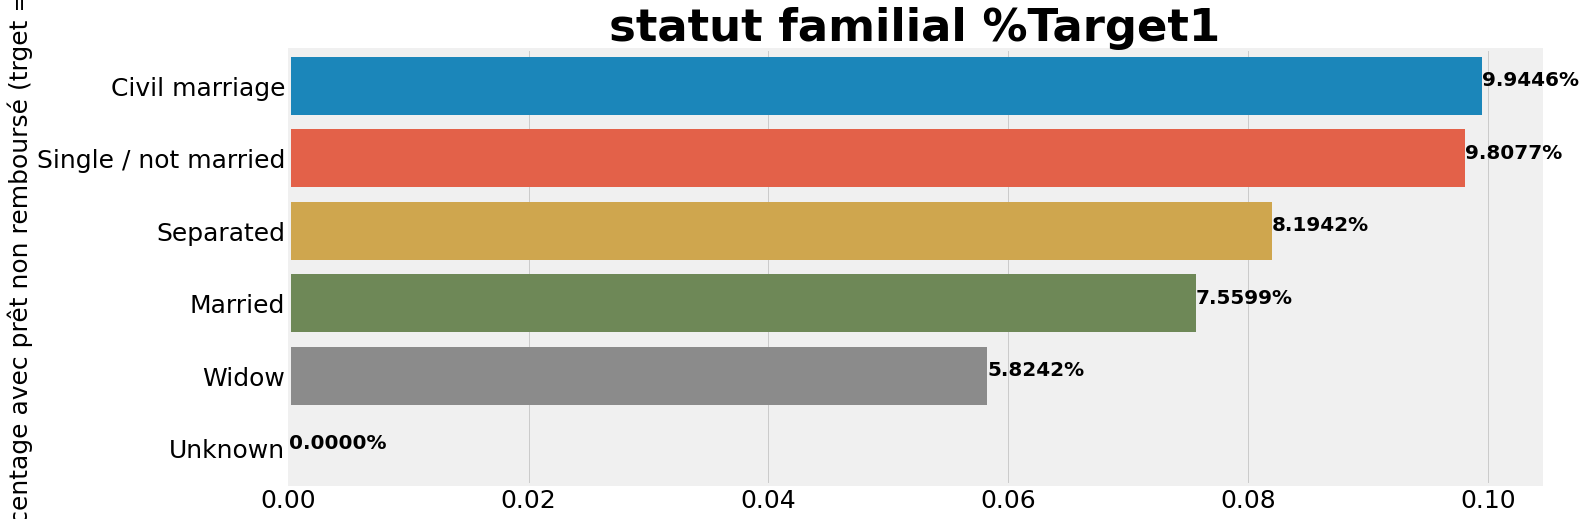

In [41]:
# Statut familial
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Statut familial")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"statut familial %Target1")

La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.

En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).

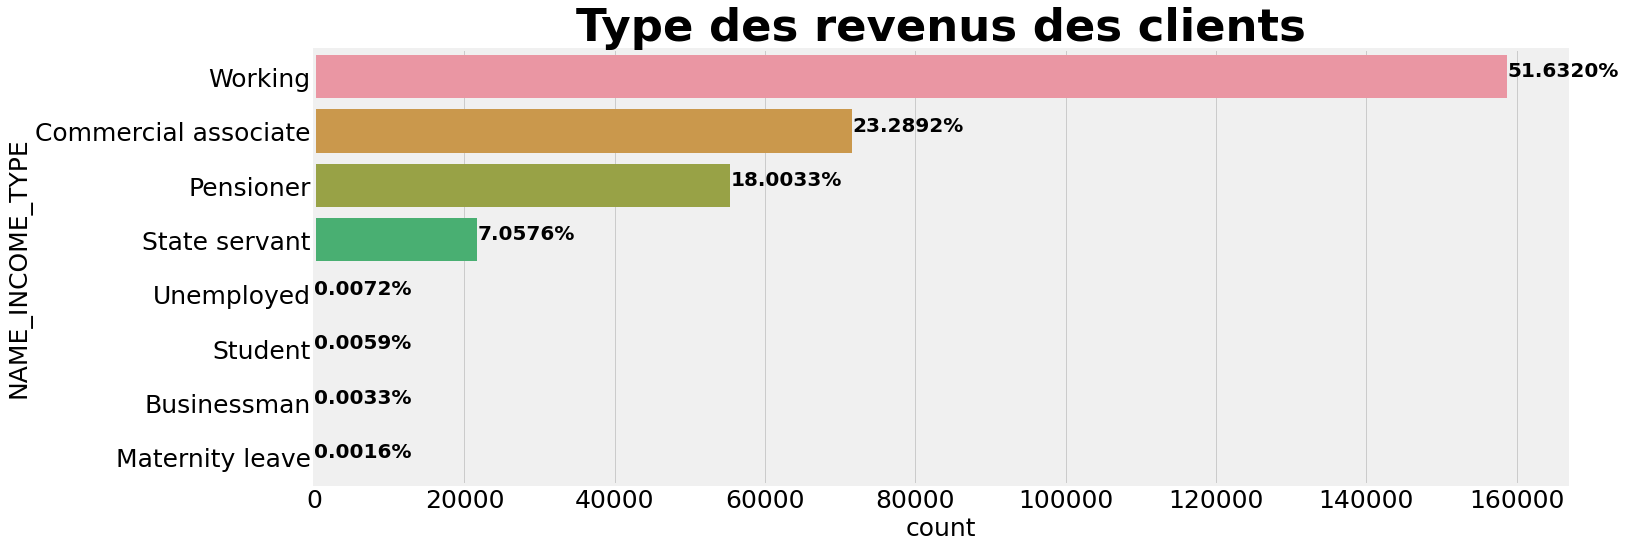

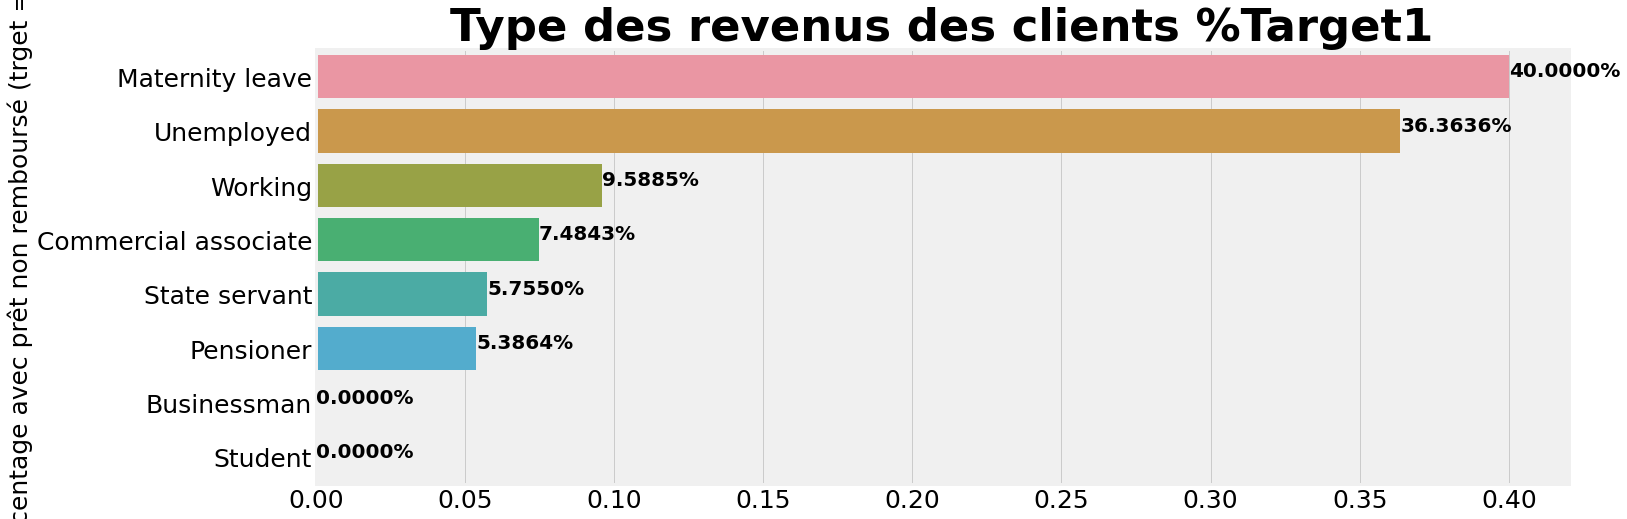

In [42]:
# Type des revenus des clients
plot_stat(application_train, 'NAME_INCOME_TYPE',"Type des revenus des clients")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Type des revenus des clients %Target1")

La plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.

Les demandeurs avec le type de revenu Congé de maternité ont un pourcentage de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à 10% pour ne pas rembourser leurs prêts.

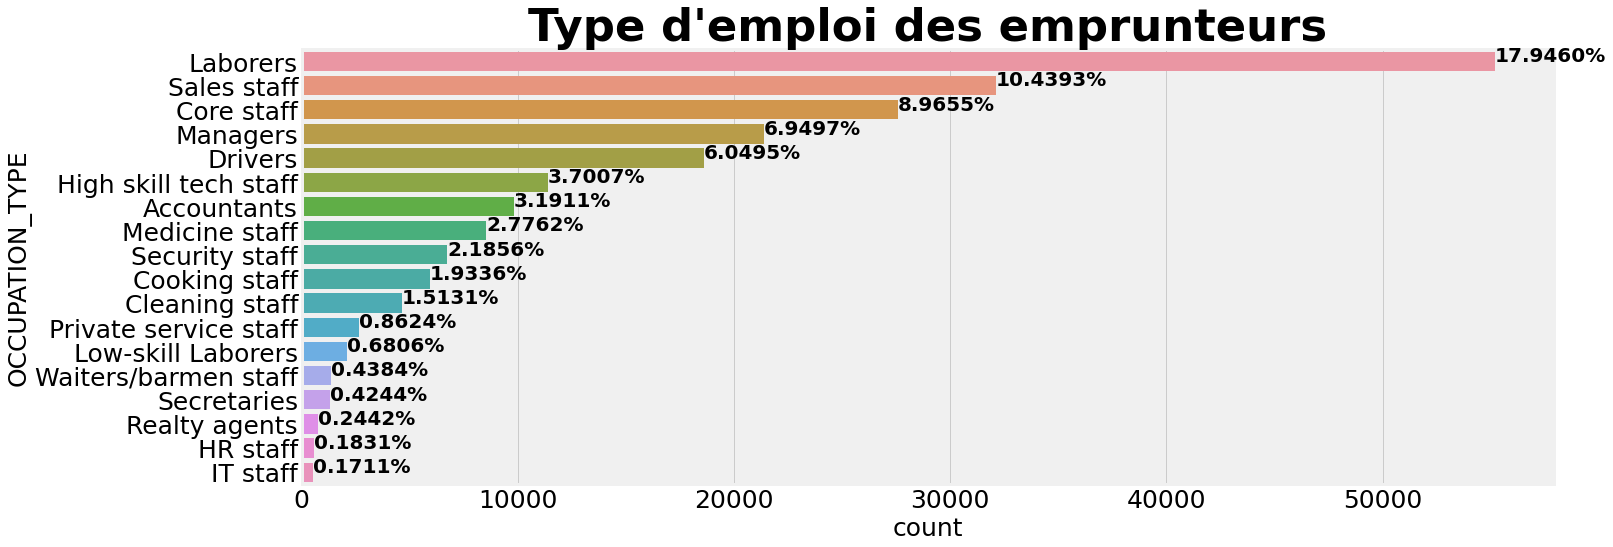

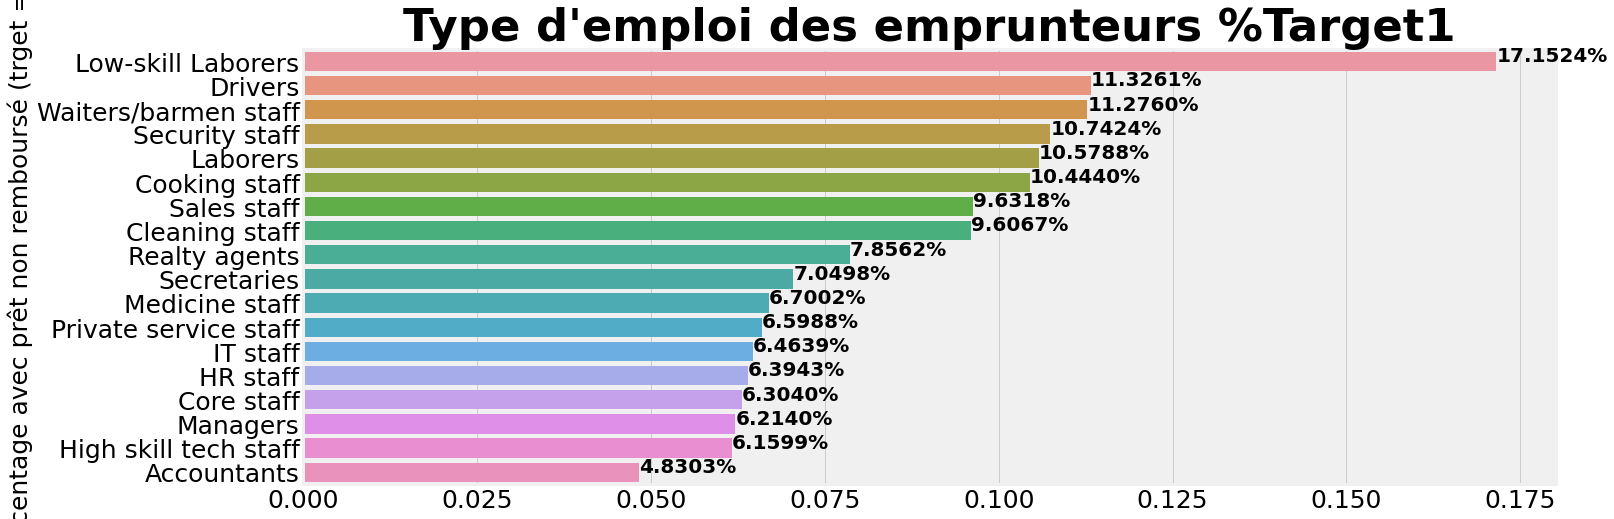

In [43]:
# Type d'emploi des emprunteurs
plot_stat(application_train, 'OCCUPATION_TYPE',"Type d'emploi des emprunteurs")
plot_percent_target1(application_train, 'OCCUPATION_TYPE',"Type d'emploi des emprunteurs %Target1")

La plupart des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux.

La catégorie ayant plus de difficulté à rembourser leur prêts est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

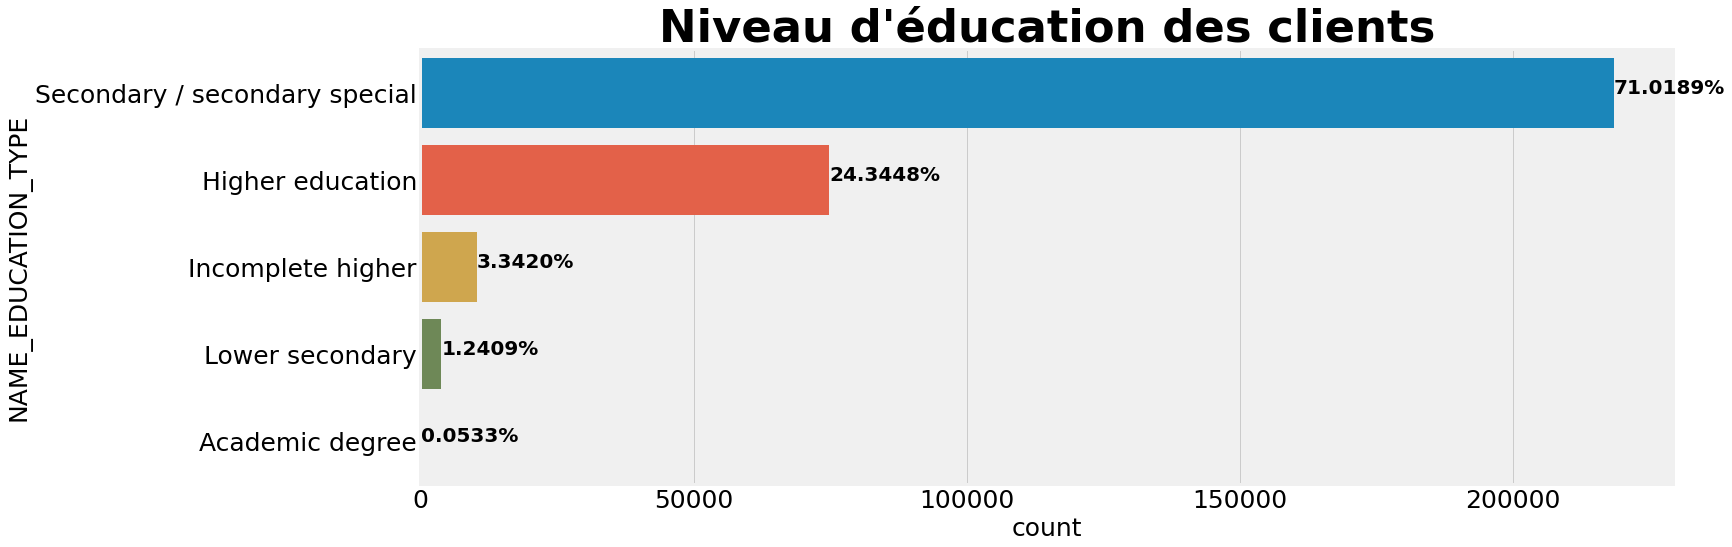

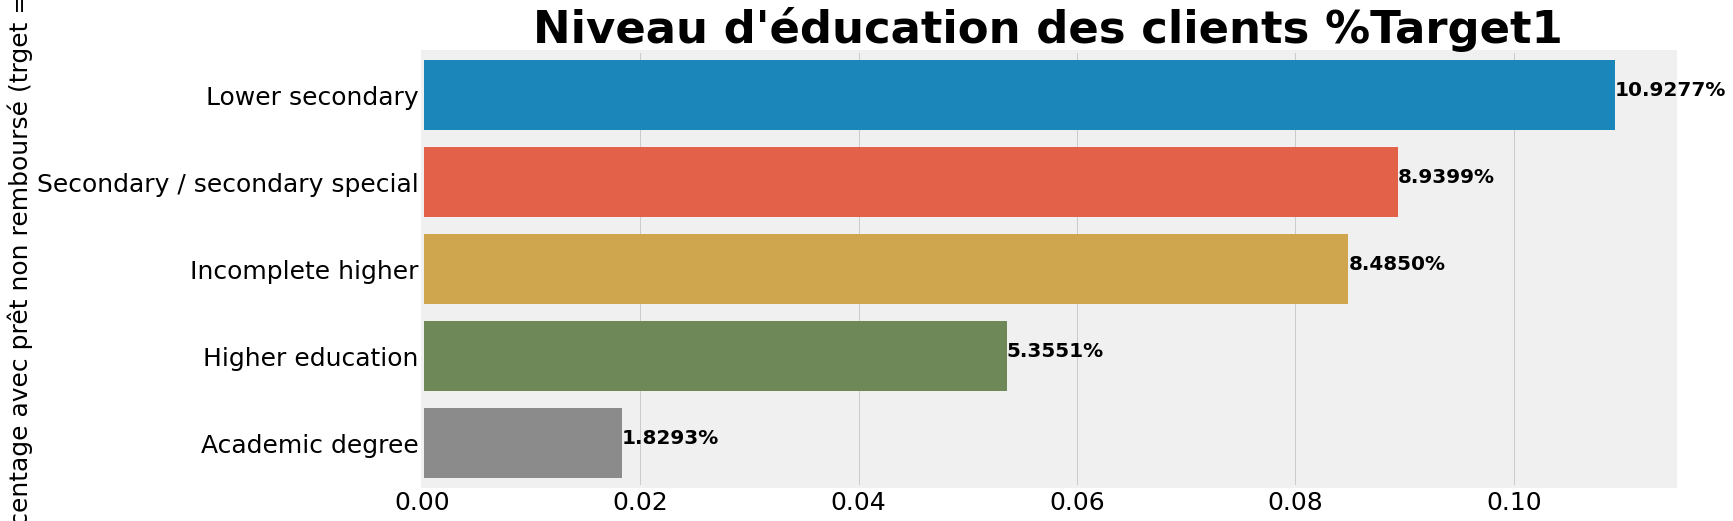

In [44]:
#Niveau d'éducation des clients
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Niveau d'éducation des clients")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Niveau d'éducation des clients %Target1")

La majorité des clients ont une éducation secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

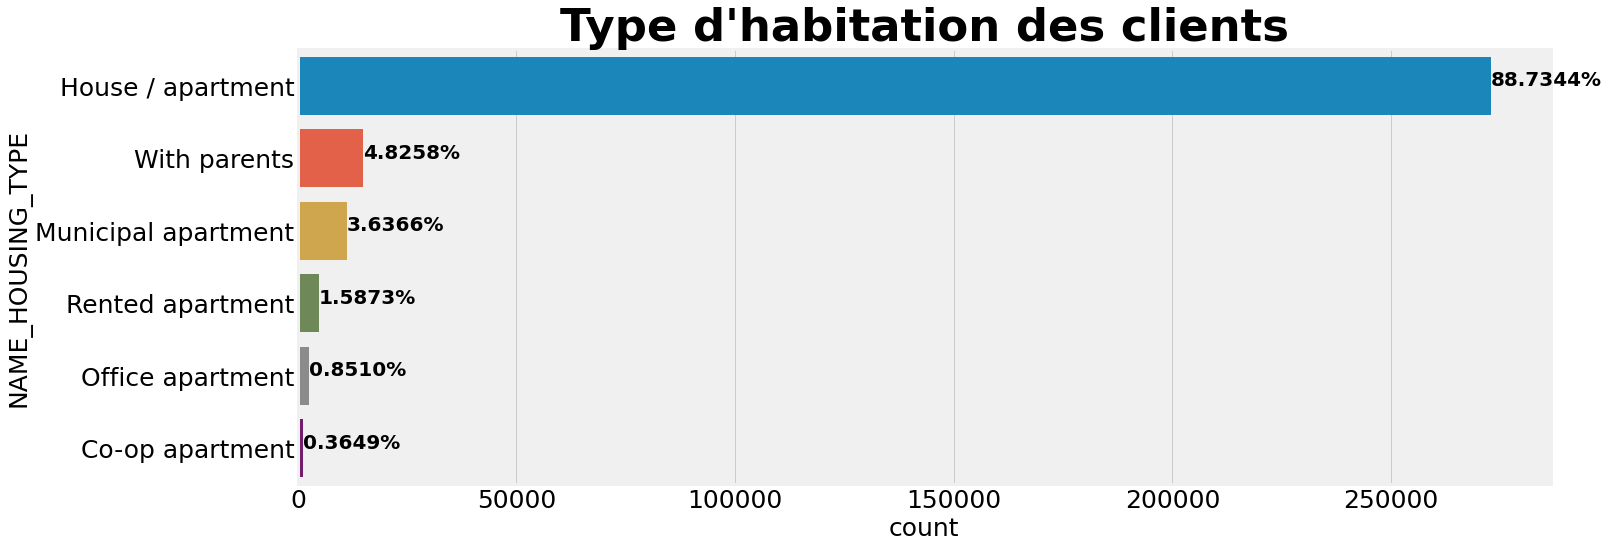

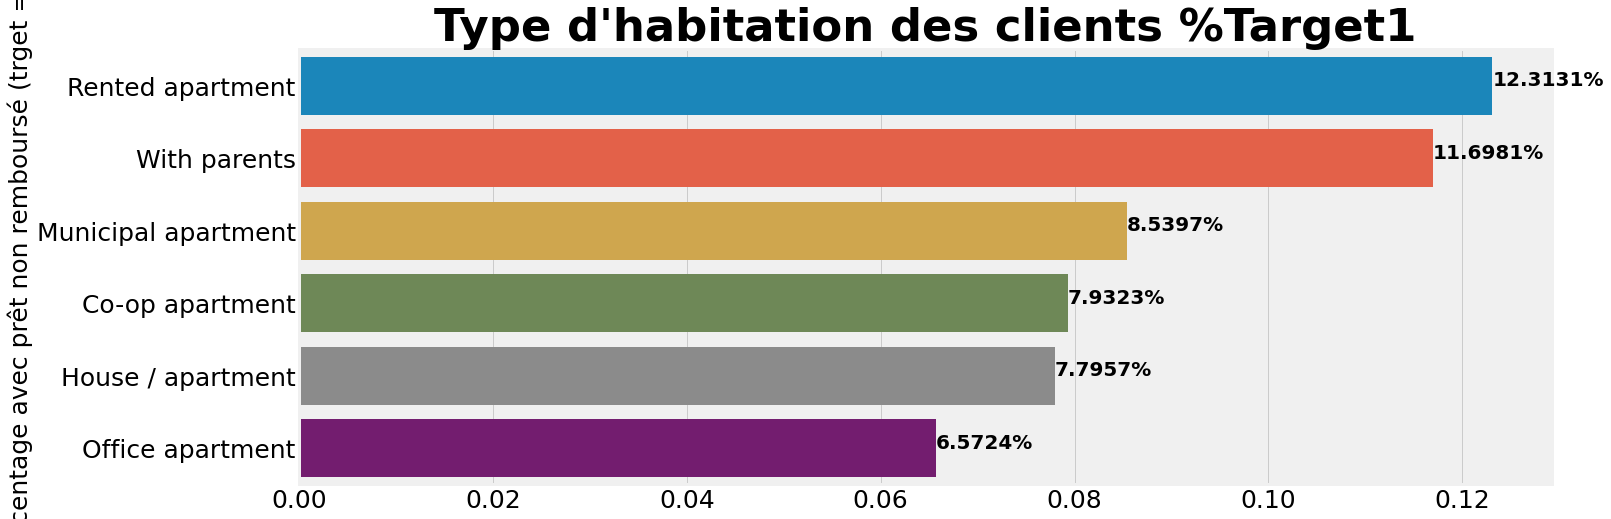

In [45]:
#Type d'habitation
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type d'habitation des clients")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type d'habitation des clients %Target1")

Plus de 88% de demandeurs de crédits vivent en maison ou appartement. Les catégories ayant un faible pourcentage, représentent une population moins "indépendante" (vivre chez ses parents, etc…).

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

#### 2 - Feature engineering <a class="anchor" id="4-bullet"></a>

In [46]:
#Création d'un simple dataset avec train / test merge app
data = application_train.append(application_test)

In [47]:
#Calcul du nombre total des précédents crédits pris par chaque client. 
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [48]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 124)

Création de 5 nouvelles variables métiers :

CREDIT_INCOME_PERCENT: Pourcentage du montant du crédit par rapport au revenu d'un client\
ANNUITY_INCOME_PERCENT: Pourcentage de la rente de prêt par rapport au revenu d'un client\
CREDIT_TERM: Durée du paiement en mois\
DAYS_EMPLOYED_PERCENT: Pourcentage des jours employés par rapport à l'âge du client\
INCOME_PER_PERSON: pourcentage des revenues des clients par rapport aux membres de la famille.


In [49]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [50]:
print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_PERCENT        -0.067955
DAYS_EMPLOYED_OUTLIERS       -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MOD

In [51]:
# rappel avec les dataframes application_train et application_test.
data_train = data[data['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]

In [52]:

data_train.shape

(307511, 129)

In [53]:
data_test.shape

(48744, 129)

In [54]:
# supprimer la variable "target" de data_test
data_test = data_test.drop('TARGET', axis=1)

In [55]:
data_train.set_index('SK_ID_CURR', inplace=True)

In [56]:

data_test.set_index('SK_ID_CURR', inplace=True)

In [57]:
print("taille de df d'entrainement: ", data_train.shape)
print('taille de df de test: ', data_test.shape)

taille de df d'entrainement:  (307511, 128)
taille de df de test:  (48744, 127)


In [58]:
# SAUVEGARDER LES DONNÉES TEST AVANT PRETRAITEMENT
data_test.to_csv('Datas/preprocessed_data.csv')  

#### 3 - Encodage des variables catégorielles <a class="anchor" id="5-bullet"></a>

In [59]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [60]:
data_train.shape

(307511, 252)

In [61]:
data_test.shape

(48744, 248)

In [62]:
# vérifions les variables qui sont différents
display(data_train.columns.difference(data_test.columns))

Index(['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown',
       'NAME_INCOME_TYPE_Maternity leave', 'TARGET'],
      dtype='object')

Il faut aligner les deux df (supprimer les différences) sauf pour la variable "TARGET" qu'on doit la sauvegarder tout d'abord.

In [63]:
#sauvegarder la variable "TARGET"
TARGET = data_train.TARGET 
# supprimer "TARGET" avant de faire l'alignement des deux dataframes
data_train.drop('TARGET', axis=1, inplace=True) 

In [64]:
data_train, data_test = data_train.align(data_test, join='inner', axis=1)

In [65]:

print(data_train.shape)
print(data_test.shape)

(307511, 248)
(48744, 248)


#### 4 - Traitement des NaN via SimpleImputer <a class="anchor" id="6-bullet"></a>

Définition des colonnes numériques et catégorielles
categorical_cols = [col for col in x.columns if x[col].dtype == 'object']
numerical_cols = list(x.drop(categorical_cols, axis=1).columns)


Vérification des valeurs infinies
count = np.isinf(x[numerical_cols]).values.sum()
print("The df contains " + str(count) + " infinite values")

Nous remplaçons les valeurs inf par NaN
x.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
imputer = SimpleImputer(strategy='median')
data_train.iloc[:,:]= imputer.fit_transform(data_train)

In [67]:
data_test.iloc[:,:] = imputer.fit_transform(data_test)

In [68]:
# vérifier les nan après imputation

print("Nombre de NaN dans data_train: ", sum(data_train.isnull().sum()))
print("Nombre de NaN dans data_test: ", sum(data_test.isnull().sum()))

Nombre de NaN dans data_train:  0
Nombre de NaN dans data_test:  0


#### 5 - Stadardisation via RobustScaler <a class="anchor" id="7-bullet"></a>

Nous utilisons la technique "Robust_scaler". Cette technique utilise le même principe de mise à l’échelle que MinMaxScaler(). Néanmoins, elle utilise l’intervalle interquartile au lieu du min-max, ce qui la rend plus fiable aux outliers.

In [69]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.fit_transform(data_test)

In [70]:
scaled_test

array([[ 0.        , -0.2       ,  0.28670721, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.52      , -0.5483927 , ...,  0.        ,
        -1.        ,  0.        ],
       [ 0.        ,  0.4       ,  0.51468288, ...,  0.        ,
        -1.        ,  0.        ],
       ...,
       [ 1.        ,  0.4       , -0.32580365, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.6       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.2       , -0.33119027, ...,  0.        ,
        -1.        ,  0.        ]])

In [71]:
# Nous allons garder les mêmes nom des variables pour les données standardisées
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [72]:
data_train.shape

(307511, 248)

In [73]:
data_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.0,-0.20,0.286707,-0.290382,0.133333,0.000000,-0.483966,-0.302900,-0.122341,0.883297,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100005,0.0,-0.52,-0.548393,-0.454693,-0.533333,0.908077,-0.319143,-1.452202,-0.832636,0.587527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.75,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
100013,0.0,0.40,0.514683,2.244264,0.577778,0.013453,-0.595575,-1.446294,0.416498,-0.098104,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
100028,2.0,1.40,2.715030,1.175203,2.911111,0.404245,0.253326,-0.054243,0.447983,-0.355215,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100038,1.0,0.20,0.423545,0.302202,0.566667,-0.472638,0.384400,-0.228786,0.088157,-0.374909,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.75,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0


In [74]:
data_test.shape

(48744, 248)

In [75]:
data_test_sample= data_test.head(100)

In [76]:
data_test_sample.shape

(100, 248)

In [77]:
# exporter les données pré-traitées vers des fichiers csv

os.makedirs('Datas/preprocessed_Data', exist_ok=True)  
data_train.to_csv('Datas/preprocessed_Data/data_train.csv')  
data_test_sample.to_csv('Datas/preprocessed_Data/data_test_sample.csv')  
#data_test_sample.to_csv('Datas/api/data_test_sample.csv')  
TARGET.to_csv('Datas/preprocessed_Data/TARGET.csv')  

# 3. Modeling<a class="anchor" id="8-bullet"></a>

## 1. Split train/test <a class="anchor" id="9-bullet"></a>

In [78]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.2, random_state=42)

In [79]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 248), (61503, 248), (246008,), (61503,))

## 2. Dummy classifiers <a class="anchor" id="10-bullet"></a>

Notre fonction de minimisation est appelée hyperparamter_tuning et l’algorithme de classification pour optimiser son hyperparamètre est DummyClassifier. J’utilise la validation croisée pour éviter le overfitting, puis la fonction retourne une valeur de perte et son état.
Cela signifie que pendant le processus d’optimisation, nous formons le modèle avec des valeurs d’hyperparamètres sélectionnées et nous prédisons la TARGET, puis nous évaluons l’erreur de prédiction et nous la rendons à l’optimiseur. L’optimiseur décidera quelles valeurs vérifier et itérer à nouveau.

best loss = -0.919 signifie que c'est un modèle avec accuracy= 91,91%

La meilleur valeur du paramètre "strategy" est celui dans la liste dont l'indice est 1 --> strategy = "prior".
Nous allons fitter le modèle sur nos données puis prédire notre target.

In [80]:
Dummy_model = DummyClassifier(strategy='prior')

In [81]:
Dummy_model.fit(X=X_train,y=y_train)

DummyClassifier()

In [82]:
def Performance(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [83]:
roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



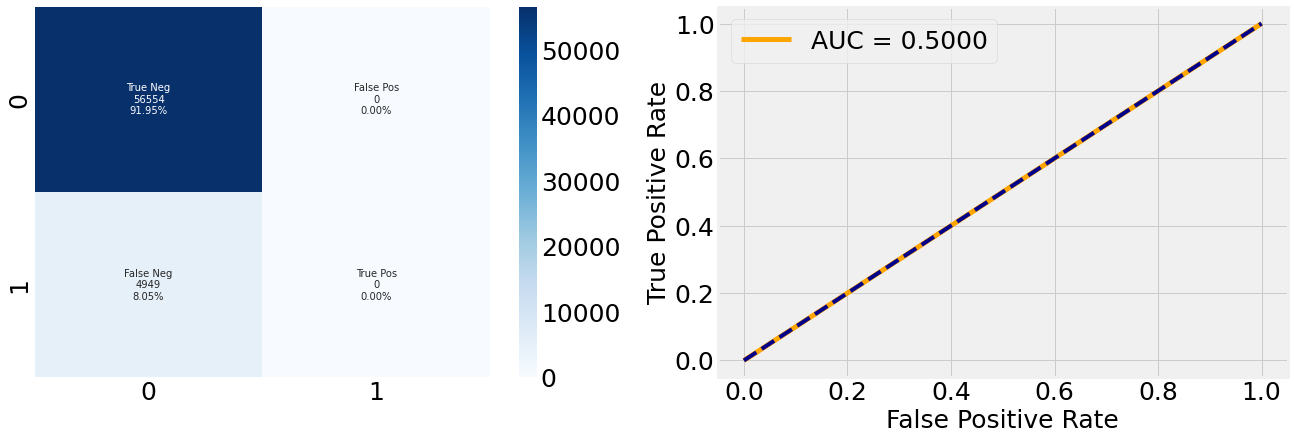

In [84]:
Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

In [85]:
# reverification des classes
print("Classe 1, avant utilisation de SMOTE: {} ".format(sum(y_train==1)))
print("Classe 0, avant utilisation SMOTE: {} ".format(sum(y_train==0)))

Classe 1, avant utilisation de SMOTE: 19876 
Classe 0, avant utilisation SMOTE: 226132 


## 3. Rééquilibrage via SMOTE <a class="anchor" id="11-bullet"></a>

over-sampling: au lieu de créer des copies exactes des enregistrements de classe minoritaire, nous pouvons introduire de petites variations dans ces copies, créant des échantillons synthétiques plus diversifiés.

In [86]:
# équilibrage des classes

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# reverification des classes
print("Classe 1, après utilisation de SMOTE: {} ".format(sum(y_train_res==1)))
print("Classe 0, après utilisation SMOTE: {} ".format(sum(y_train_res==0)))

## 4. Re-entrainement après rééquilibrage des classes <a class="anchor" id="12-bullet"></a>

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65     56554
         1.0       0.08      0.49      0.14      4949

    accuracy                           0.50     61503
   macro avg       0.50      0.50      0.39     61503
weighted avg       0.85      0.50      0.61     61503



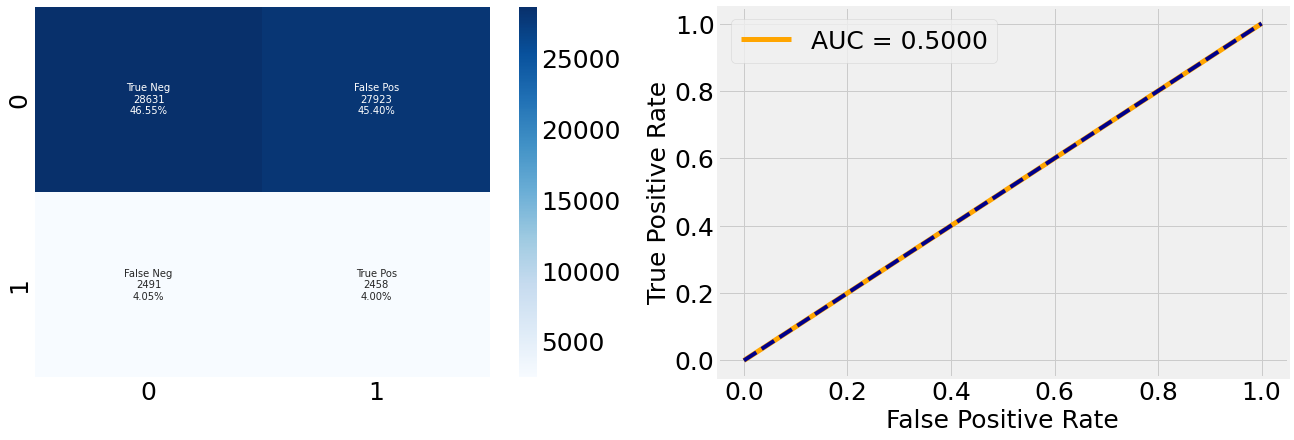

In [87]:
Dummy_model = DummyClassifier(strategy='uniform')
Dummy_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

## 5. Test de modèles de classification <a class="anchor" id="13-bullet"></a>

### 1 - RidgeClassifier <a class="anchor" id="14-bullet"></a>

AUC : 0.6778
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     56554
         1.0       0.16      0.66      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



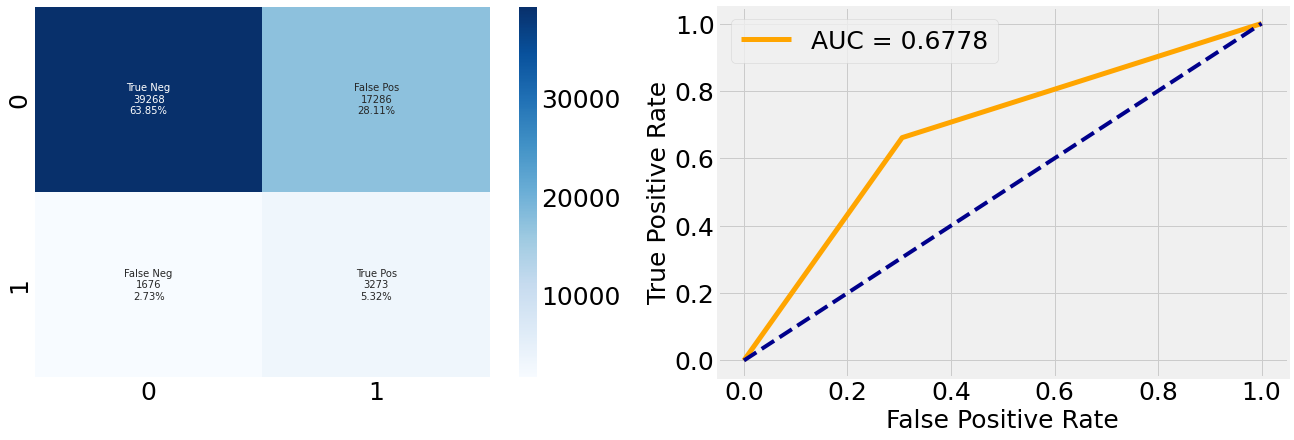

In [88]:
rc_model = RidgeClassifier()
rc_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, rc_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rc_model.predict(X_test)))

Performance(rc_model, y_test, rc_model.predict(X_test), rc_model.predict(X_test))

### 2 - LogisticRegression <a class="anchor" id="15-bullet"></a> 

AUC : 0.6751
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56554
         1.0       0.16      0.66      0.25      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



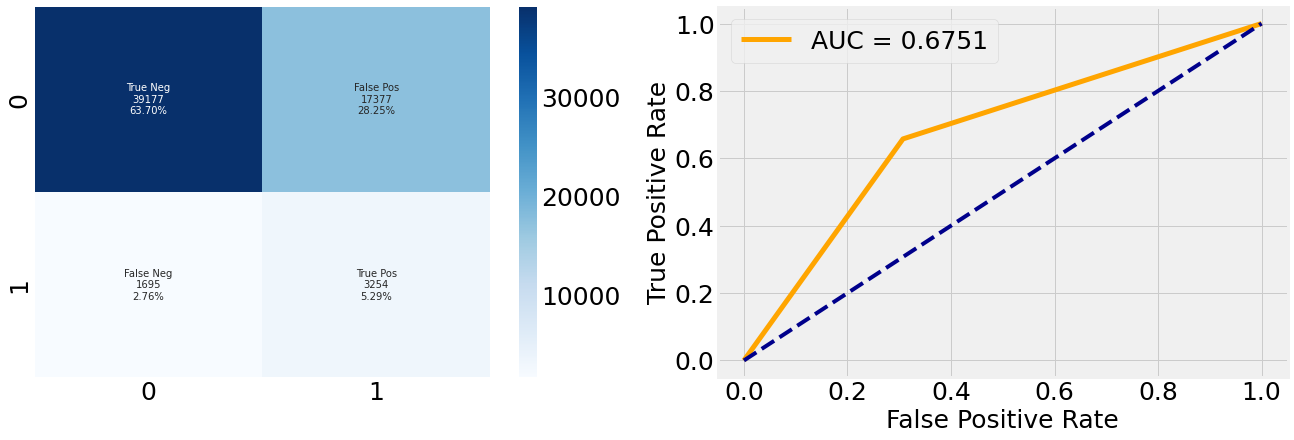

In [89]:
lr_model = LogisticRegression()
lr_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, lr_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr_model.predict(X_test)))

Performance(lr_model, y_test, lr_model.predict(X_test), lr_model.predict(X_test))

### 3 - SGDClassifier <a class="anchor" id="16-bullet"></a> 

AUC : 0.6207
              precision    recall  f1-score   support

         0.0       0.95      0.60      0.73     56554
         1.0       0.12      0.64      0.21      4949

    accuracy                           0.60     61503
   macro avg       0.54      0.62      0.47     61503
weighted avg       0.88      0.60      0.69     61503



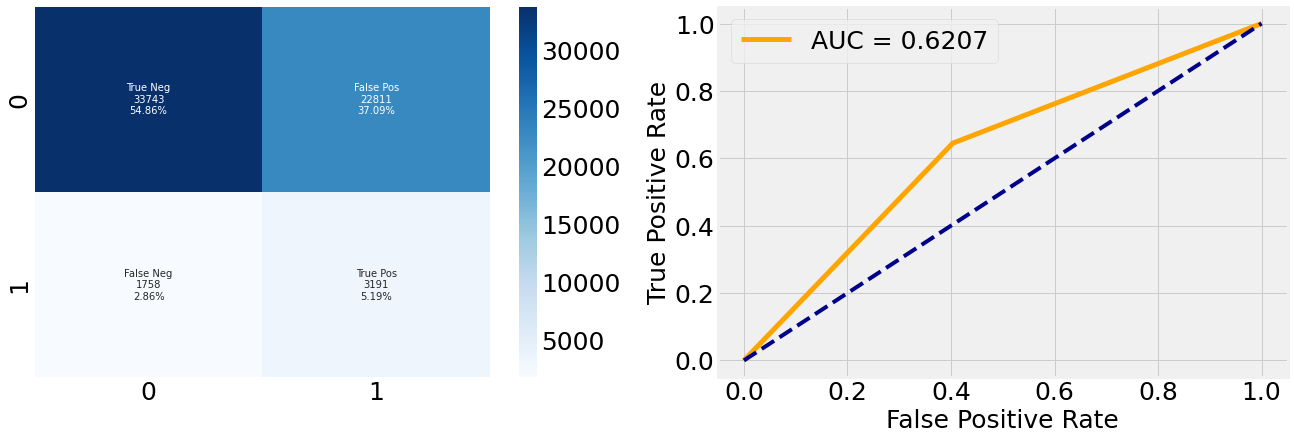

In [90]:
sgd_model = SGDClassifier()
sgd_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, sgd_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, sgd_model.predict(X_test)))

Performance(sgd_model, y_test, sgd_model.predict(X_test), sgd_model.predict(X_test))

### 4 - DecisionTreeClassifier <a class="anchor" id="17-bullet"></a> 

AUC : 0.5401
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91     56554
         1.0       0.14      0.18      0.16      4949

    accuracy                           0.84     61503
   macro avg       0.53      0.54      0.53     61503
weighted avg       0.86      0.84      0.85     61503



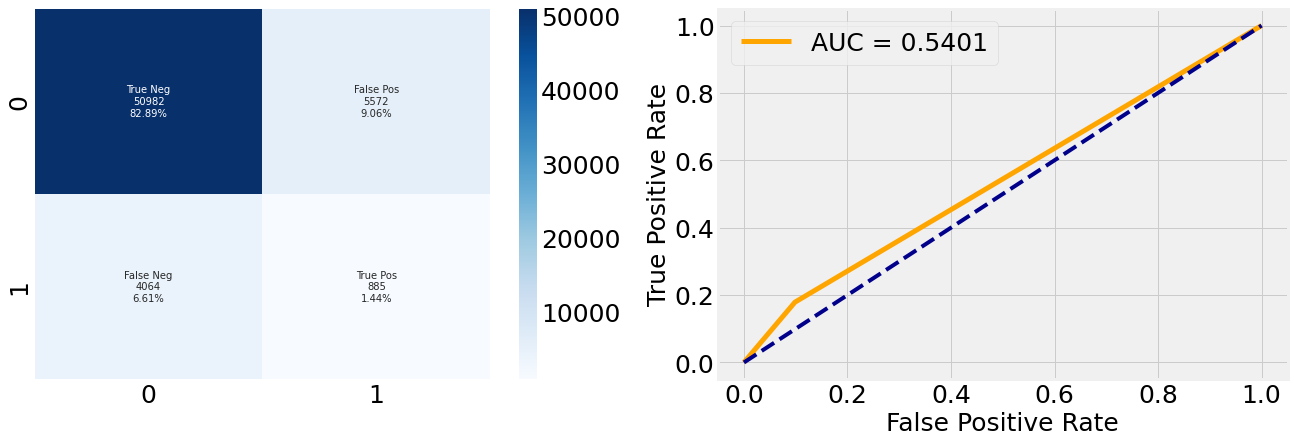

In [91]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, dt_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dt_model.predict(X_test)))

Performance(dt_model, y_test, dt_model.predict(X_test), dt_model.predict(X_test))

### 5 - RandomForestClassifier <a class="anchor" id="18-bullet"></a> 

Les forêts aléatoires fonctionnent en faisant la moyenne des prédictions de nombreux arbres de décision - l’idée est qu’en faisant la moyenne de nombreux arbres, les erreurs de chaque arbre sont aplanies. Chaque arbre de décision peut être quelque peu overfitted, en faisant la moyenne, le résultat final devrait être bon.

Les paramètres importants à régler sont :

Nombre d’arbres dans la forêt (n_estimators) Complexité de l’arborescence (max_depth)

AUC : 0.5012
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.33      0.00      0.01      4949

    accuracy                           0.92     61503
   macro avg       0.62      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



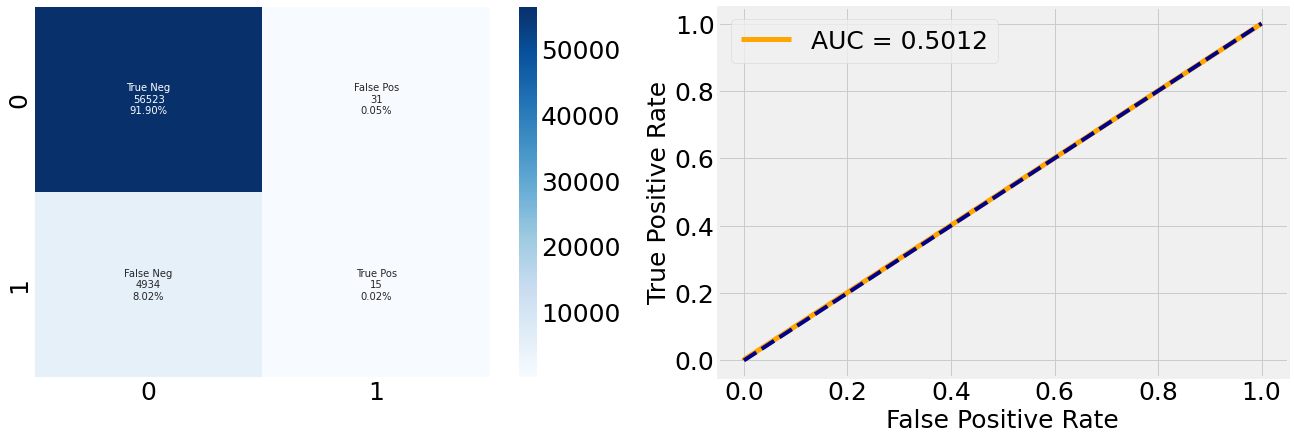

In [92]:
rf_model = RandomForestClassifier()
rf_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, rf_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rf_model.predict(X_test)))

Performance(rf_model, y_test, rf_model.predict(X_test), rf_model.predict(X_test))

### 6 - XGBoost <a class="anchor" id="19-bullet"></a> 

XGBoost est également basé sur un ensemble d’arbres de décision, mais différent de la forêt aléatoire. Les arbres ne sont pas moyennés, mais ajoutés. Les arbres de décision sont formés pour corriger les résidus des arbres précédents. L’idée est que de nombreux petits arbres de décision sont formés, chacun ajoutant un peu d’information pour améliorer les prévisions globales.

Les paramètres les plus importants sont :

Nombre d’arbres (n_estimators)
Taux d’apprentissage - les arbres postérieurs ont moins d’influence (taux d’apprentissage)
Complexité de l’arborescence (max_depth)
Gamma - Faire des arbres individuels conservateurs, réduire le overfitting
échantillon de colonne par arbre - réduire le overfitting

AUC : 0.5170
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.45      0.04      0.07      4949

    accuracy                           0.92     61503
   macro avg       0.69      0.52      0.51     61503
weighted avg       0.88      0.92      0.89     61503



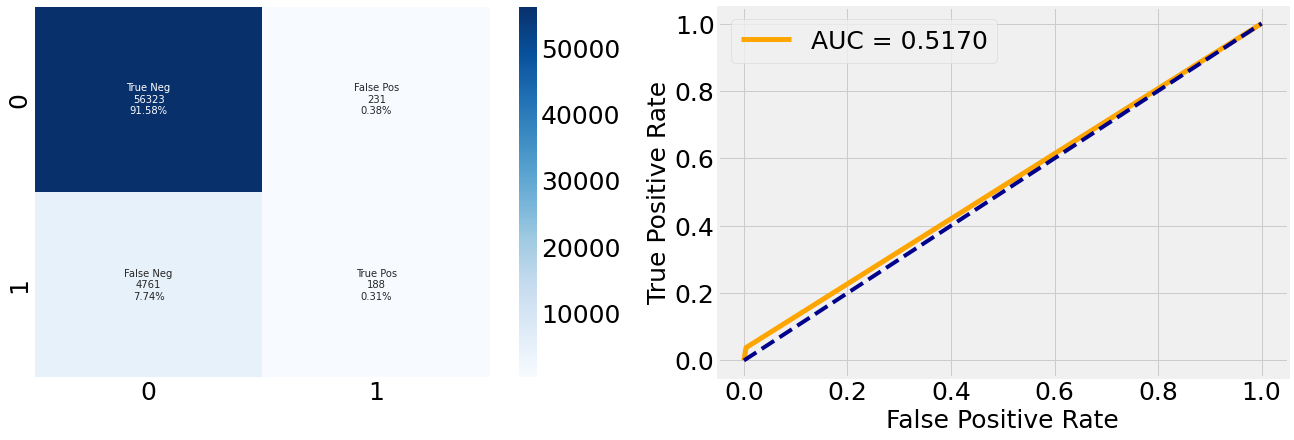

In [93]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict(X_test))

Les meilleurs résultats sont donnés par XGBoost et RandomForestClassifier.
Nous posons l'hypothèse qu'au vue des sommes engagées dans les prêts, nous aurons des ressources en conséquence. Nous ne retenons pas la ressource mémoire utilisée dans ce projet. 
Nous allons étudier, les pourcentages de faux-positifs et des faux-négatifs donnés par chaque algorithme.
Le Faux-négatif est plus important à éviter puisqu'il signifie qu'un prêt est donné pour un client qui ne peut pas le remboursé, donc la perte touche la capitale de la banque. Par contre, le Faux-positif signifie qu'un client qui pourra rembourser son prêt a eu un refus de la part de la banque, donc la perte touche la marge. Le faux négatif est plus dangereux et donc nous allons choisir le modèle qui résulte moins de faux-négatif.

## 6. Fine-tuning <a class="anchor" id="20-bullet"></a> 

### 1 - Fine-tuning RandomForest <a class="anchor" id="21-bullet"></a> 

In [94]:
space =  {
        ('n_estimators', hp.quniform('n_estimators', 25, 500, 25))
        }

In [95]:
def hyperparameter_tuning(params):
    params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth'])}
    clf = RandomForestClassifier(n_jobs=4, **params)
    roc_auc = cross_val_score(clf, X_train_res, y_train_res,scoring="roc_auc", cv=StratifiedKFold()).mean()
    return {"loss": -roc_auc, "status": STATUS_OK}

In [96]:
space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

In [97]:
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

100%|███████| 10/10 [44:15<00:00, 265.58s/trial, best loss: -0.9520825531786963]


In [98]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'max_depth': 8.0, 'n_estimators': 100.0}


AUC : 0.6825
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     56554
         1.0       0.19      0.24      0.21      4949

    accuracy                           0.86     61503
   macro avg       0.56      0.57      0.57     61503
weighted avg       0.87      0.86      0.86     61503



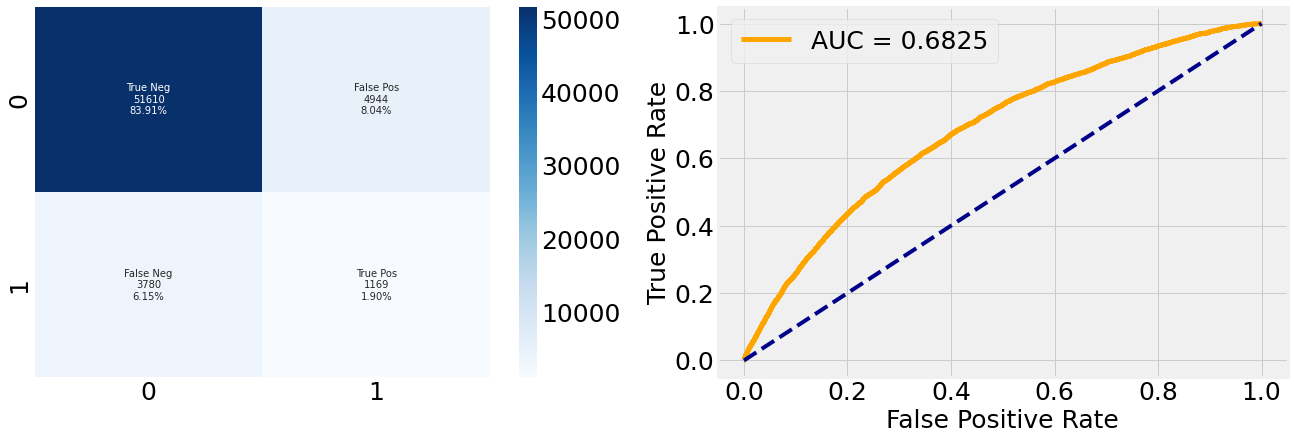

In [99]:
rf_model = RandomForestClassifier(n_estimators = 75 , max_depth=  9)
rf_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rf_model.predict(X_test)))

Performance(rf_model, y_test, rf_model.predict(X_test), rf_model.predict_proba(X_test)[:,1])

### 2 - Fine-tuning XGBOOST <a class="anchor" id="22-bullet"></a> 

In [100]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

In [101]:
def hyperparameter_tuning(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params)
    roc_auc = cross_val_score(clf, X_train_res, y_train_res,scoring="roc_auc", cv=StratifiedKFold()).mean()
    return {"loss": -roc_auc, "status": STATUS_OK}

In [ ]:
best = fmin(
    fn = hyperparameter_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 10
)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.36, gamma= 0.18 , max_depth= 8)
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1])

## 7. Fonction de coût métier et réentrainement d’XGBOOST <a class="anchor" id="23-bullet"></a> 

La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Par manque d'expertise métier, nous mettons comme hypothèse q'un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte. Nous proposons donc cette fonction pour calculer le nouveau fscore à minimiser:

    fscore = poids*fn +fp

avec:

fp: faux positif\
fn: faux négatif\
poids: importance de fn par rapport à fp. Nous avons choisi poids = 10.\
Notre approche: Une fois le modèle choisi et les hyperparamètres optimisés finement d’un point de vue technique via l’AUC, nous allons calculer une fonction de coût métier "fscore" et de trouver son minimum. Nous allons effectuer une nouvelle recherche des hyper-paramètres se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l’entreprise.

In [ ]:
def custom_score(y_true, y_pred, poids) :
    '''fonction qui pénalise le faux positive (fp) et le faux négatif (fn)'''
    
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
    fscore = poids*fn +fp
    return fscore

In [ ]:
# redéfinir la fonction hyperparameter_tuning

def hyperparameter_tuning(params):
    ''' 
      fonction objective à minimiser
      hyperopt va chercher à minimiser la perte retournée par cette fonction
    '''
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    #initialisation des hyperparamètres
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params)
    
    y_pred = cross_val_predict(clf, X_train_res, y_train_res, method='predict', cv=StratifiedKFold(5))
    score = custom_score(y_train_res, y_pred, 10)
    return {"loss": -score, "status": STATUS_OK}

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

In [ ]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=3
    
)

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
X_train_res_copy = X_train_res.copy()
X_test_copy = X_test.copy()
y_train_res_copy = y_train_res.copy()
y_test_copy = y_test.copy()

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.386, gamma= 0.289 , max_depth= 7)
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1])

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train_res.shape, X_test.shape, y_train_res.shape, y_test.shape

In [ ]:
X_test

## 8. Feature importance <a class="anchor" id="24-bullet"></a> 

Pour extraire des informations du modèle, la première étape est sûrement l’approche globale qui consiste à définir l’importance des variables du modèle de manière globale. La seconde étape consiste à changer d’échelle afin d’extraire des informations locales pour des exemples spécifiques de notre dataset.

LIME (Local Interpretable Model-agnostic Explanations) et SHAP (SHapley Additive exPlanations) sont deux bonnes méthodes pour expliquer les modèles. En théorie, SHAP est la meilleure approche car elle fournit des garanties mathématiques pour la précision et la cohérence des explications. En pratique, l’implémentation de SHAP (KernelExplainer) est lente. Ce problème de vitesse est beaucoup moins préoccupant si vous utilisez un modèle basé sur une arborescence. Pour LIME, l'inconvénient majeur c'est le biais dû à une hypothèse de non-corrélation entre features. En effet, l’échantillon d’entraînement de données généré à partir de l’instance qui nous intéresse, ne prend pas en compte les corrélations potentielles entre les features du modèle, ce qui peut donner des combinaisons de valeurs aberrantes, par exemple un appartement de 20m2 composé de 4 pièces.

Pour ces raisons, nous utilisons SHAP

In [ ]:
# compute SHAP values
explainer = shap.Explainer(xgb_model, X_train_res)
shap_values = explainer(X_train_res)

In [ ]:
X_train_res.shape

In [ ]:
# convertir le numpy array vers un pandas dataframe afin de pouvoir appliquer les méthodes de SHAP
df_xtrain = pd.DataFrame(X_train_res, 
             columns=data_train.columns)

df_xtest = pd.DataFrame(X_test, 
             columns=data_train.columns)

In [ ]:
# compute SHAP values
explainer = shap.Explainer(xgb_model, df_xtrain)

In [ ]:
shap_values = explainer(df_xtest)

### 1 - Feature importance globale <a class="anchor" id="25-bullet"></a> 

In [ ]:
shap.summary_plot(shap_values, df_xtest, plot_type="bar")

In [ ]:
# global feature importance
shap.plots.bar(shap_values)

### 2 - Feature importance locale <a class="anchor" id="26-bullet"></a> 

In [ ]:
# probabilité de prediction du client N°0
xgb_model.predict_proba(X_test)[0]

In [ ]:
# prédiction du modèle
xgb_model.predict(X_test)[0]

In [ ]:
# local feature importance pour le premier client
shap.plots.bar(shap_values[0])

In [ ]:
x= xgb_model.predict(X_test)

In [ ]:
# extraire les indices des clients dont leur prêt est refusé
x_refus = [i for i in range(len(x)) if x[i] == 1]
x_refus

In [ ]:
# choisir client d'indice = 810
xgb_model.predict_proba(X_test)[810]

In [ ]:
shap.plots.bar(shap_values[810])

In [ ]:
# sauvegarder le modèle

pickle.dump(xgb_model, open('api/model.pickle', 'wb'))